In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches
from matplotlib import pylab
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, accuracy_score
from sklearn.svm import SVC

In [2]:
# load sequence data
sequence_data = pd.read_csv('Waltz_Data_Filtered')

training_data = sequence_data.drop(['Classification', 'Sequence'], axis = 1)
target_data = sequence_data['Classification']

In [3]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(training_data, target_data, test_size = 0.2, random_state = 0)

# Set the parameters by cross-validation
linear_parameters = [{'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
rbf_parameters = [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1]}]

classifier_linear = GridSearchCV(SVC(probability = True), linear_parameters, cv = 10, scoring='roc_auc')
classifier_linear.fit(X_train, y_train)

classifier_rbf = GridSearchCV(SVC(probability = True), rbf_parameters, cv = 10, scoring='roc_auc')
classifier_rbf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [4]:
# save grid search results to variables, for plotting
linear_C = list(classifier_linear.cv_results_['param_C'])
linear_results = classifier_linear.cv_results_['mean_test_score']

rbf_C = list(classifier_rbf.cv_results_['param_C'])
rbf_gamma = list(classifier_rbf.cv_results_['param_gamma'])
rbf_results = classifier_rbf.cv_results_['mean_test_score']

In [5]:
# separate out results for each gamma value
rbf_gamma_1_results = []
rbf_gamma_01_results = []
rbf_gamma_001_results = []

lookup = {'0.1' : rbf_gamma_1_results,
          '0.01' : rbf_gamma_01_results,
          '0.001' : rbf_gamma_001_results
         }

for i in range(0, len(rbf_gamma)):
    gamma_list = lookup[str(rbf_gamma[i])]
    gamma_list.append(rbf_results[i])

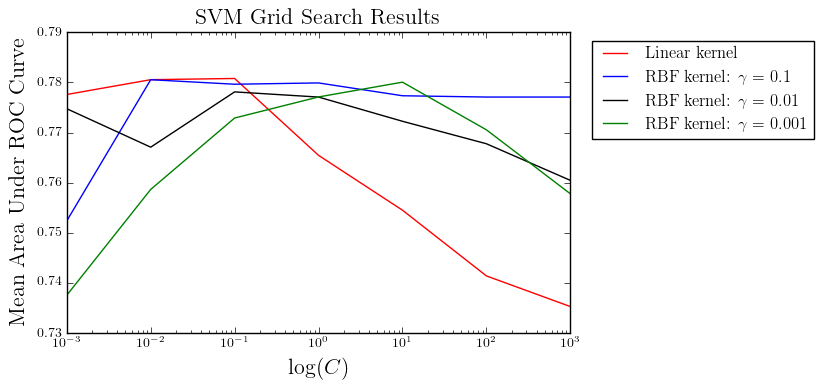

In [6]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cm'

plt.semilogx(linear_C, linear_results, color = 'red')
plt.semilogx(linear_C, rbf_gamma_1_results, color = 'blue')
plt.semilogx(linear_C, rbf_gamma_01_results, color = 'black')
plt.semilogx(linear_C, rbf_gamma_001_results, color = 'green')

ax = plt.gca()
ax.set_title('SVM Grid Search Results', fontsize = 16)
ax.set_xlabel(r'$\log(C)', fontsize = 16)
ax.set_ylabel('Mean Area Under ROC Curve', fontsize = 16)

linear_line = mlines.Line2D([], [], linestyle = '-', color = 'red', label = 'Linear kernel')
gamma_1 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = r'RBF kernel: $\gamma = 0.1$')
gamma_01 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = r'RBF kernel: $\gamma = 0.01$')
gamma_001 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = r'RBF kernel: $\gamma = 0.001$')
plt.legend(handles = [linear_line, gamma_1, gamma_01, gamma_001], loc = 'upper right', frameon = True, bbox_to_anchor=(1.5, 1))

plt.tight_layout()
plt.show()

In [7]:
# apply fitted SVM classifier with best hyperparameters to test data
y_score_pairs = classifier_linear.best_estimator_.predict_proba(X_test)

# create array of probability scores for each hexapeptide
y_score_pos = []
for pair in y_score_pairs:
    y_score_pos.append(pair[1])

In [8]:
# calculate values needed for ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, y_score_pos)

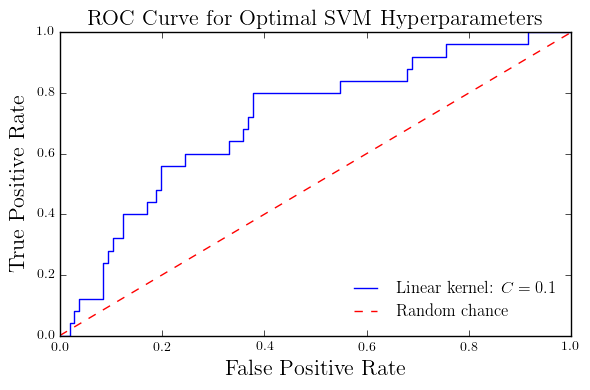

In [9]:
# plot ROC curve
plt.plot(false_pos_rate, true_pos_rate)
ax = plt.gca()
ax.set_title('ROC Curve for Optimal SVM Hyperparameters', fontsize = 16)
ax.set_xlabel('False Positive Rate', fontsize = 16)
ax.set_ylabel('True Positive Rate', fontsize = 16)

plt.plot(np.linspace(0, 1), np.linspace(0, 1), linestyle = '--', color = 'red')

ROC_curve = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = r'Linear kernel: $C = ' + str(classifier_linear.best_estimator_.C) + '$')
rand_chance = mlines.Line2D([], [], linestyle = '--', color = 'red', label = r'Random chance')
plt.legend(handles = [ROC_curve, rand_chance], loc = 'lower right', frameon = False)

plt.tight_layout()
plt.show()

In [10]:
# find best probability threshold
ROC_line = list(zip(false_pos_rate, true_pos_rate))

# search for point on ROC line that is closest to point (0, 1)
best = (1, 0)
best_dist = 1
best_index = 0
for i in range(0, len(ROC_line)):
    new_dist = np.sqrt((0 - ROC_line[i][0]) + (1 - ROC_line[i][1]))
    if (new_dist < best_dist):
        best = ROC_line[i]
        best_index = i

# find best probability threshold
best_theshold = thresholds[best_index]
print('best probability threshold =', best_theshold)

best probability threshold = 0.141583102596


In [11]:
y_test_predicted = []
for probability in y_score_pos:
    if (probability >= best_theshold):
        y_test_predicted.append(1)
    else:
        y_test_predicted.append(0)

In [12]:
matthews_corrcoef(y_test, y_test_predicted)

0.2247365181317319

In [13]:
matthews_corrcoef(y_test, classifier_linear.best_estimator_.predict(X_test))

-0.060469616511011015

In [14]:
accuracy_score(y_test, classifier_linear.best_estimator_.predict(X_test))

0.79389312977099236